<a href="https://colab.research.google.com/github/Dicere/WB_Internship/blob/main/0_8_model_new_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier,Pool
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, recall_score, precision_recall_curve,precision_score, precision_recall_fscore_support
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WB_стажировка/wb_school_task_2.csv.gzip',compression='gzip')
df = df.drop_duplicates(ignore_index=True)

In [ ]:
kvad_sum=(lambda x: sum(i**2 for i in x))
kvad_sum.__name__ = 'kvad_sum'

interkvartil_razmah = (lambda x: np.percentile(x, 75) - np.percentile(x, 25))
interkvartil_razmah.__name__ = 'interkvartil_razmah'

range_dannih = (lambda x: x.max()-x.min())
range_dannih.__name__ = 'range_dannih'

quant90 = lambda x: x.quantile(0.9)
quant90.__name__ = 'quant90'

In [ ]:
aggs_list = ['min','max', 'mean', 'median', 'count', 'sum',kvad_sum,interkvartil_razmah,range_dannih,quant90]

In [ ]:
df_agg = df[['id3','f1','f2','f3','f4','f5','f6','f7','f8']].groupby(by=['id3']).agg(aggs_list).reset_index()
df_agg.columns = ['_by_id3_'.join(col) for col in df_agg.columns.values]
df_agg = df_agg.rename(columns={'id3_by_id3_':'id3'})

In [ ]:
df1 = pd.merge(df,df_agg,how='left',on=['id3'])

In [ ]:
clear_df = df1[['f1','f2','f3','f4','f5','f6','f7','f8','f1_by_id3_sum', 'f2_by_id3_sum', 'f3_by_id3_sum', 'f4_by_id3_sum',
       'f5_by_id3_sum', 'f6_by_id3_sum', 'f7_by_id3_sum', 'f8_by_id3_sum']]

In [ ]:
feature_dict = {}
def summ(b=0,i=0):
  name = str('sum_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
  feature_dict[name] = clear_df.iloc[:,b] + clear_df.iloc[:,i]
def subtraction(b=0,i=0):
    name = str('subtraction_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] - clear_df.iloc[:,i])
def multiplication(b=0,i=0):
    name = str('multiplication_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] * clear_df.iloc[:,i])
def division(b=0,i=0):
    name = str('division_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs((clear_df.iloc[:,b] / clear_df.iloc[:,i]).fillna(0))
    name = str('division_'+clear_df.columns[i]+"_"+clear_df.columns[b])
    feature_dict[name] = abs((clear_df.iloc[:,i] /clear_df.iloc[:,b]).fillna(0))

In [ ]:
conversions_list = {'sum':summ,'subtraction':subtraction,'division':division,'multiplication':multiplication}

In [ ]:
idx=0
for conv in conversions_list.keys():
  for b in range(len(clear_df.columns)-1):
    if conv == 'multiplication':
      for i in range(b,len(clear_df.columns)):
        conversions_list[conv](b,i)
    else:
      for i in range(b+1,len(clear_df.columns)):
        conversions_list[conv](b,i)


In [ ]:
df1 = df1.assign(**feature_dict)

<ipython-input-13-56533d6d9c93>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1 = df1.assign(**feature_dict)
<ipython-input-13-56533d6d9c93>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1 = df1.assign(**feature_dict)
<ipython-input-13-56533d6d9c93>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.co

In [ ]:
cols_to_drop = df1.columns[df1.nunique() == 1]
df1 = df1.drop(cols_to_drop, axis=1)
df1.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
X = df1[df1.drop('label', axis=1).columns[4::]]
y=df1.label

In [ ]:
N_SPLITS = 7
current_feat = list(X.columns[:8])

In [ ]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f7_by_id3_mean', 'sum_f3_f6', 'division_f1_f2', 'division_f4_f7', 'division_f7_f5', 'division_f7_f8', 'multiplication_f3_f3']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify=y)

In [ ]:
def calc_log_loss_weight(y_true):
    y_true = y_true.astype(int)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    return w0, w1

In [ ]:
def plot(scores,best_score,text):
  plt.figure(figsize=(20,5))
  plt.plot(thresholds,scores,'-o',color='blue')
  plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
  plt.xlabel('Threshold',size=14)
  plt.ylabel(f'Validation {i}',size=14)
  plt.title(f'Threshold vs. {i} with Best {i}= {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
  plt.show()

In [ ]:
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=22)
indx_all = X_train.index

oof = pd.DataFrame(data=np.zeros((len(indx_all),1)), index=indx_all)
# params_grid = {'bootstrap_type': 'MVS',
#         'iterations': 800,
#         'learning_rate': 0.259,
#         'max_depth': 3,
#         'objective': 'Logloss',
#         'verbose': 200,
#         'eval_metric': 'AUC',
#         'border_count': 32,
#         'colsample_bylevel': 0.09715577437674092,
#         'min_data_in_leaf': 20,
#         'random_strength': 0.36494249753665964,
#         'scale_pos_weight': 0.4366210135974975
#         }

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
models=[]
for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    print('#'*25)
    print('### CV_Fold',idx+1)
    print('#'*25)

    X_train_сv, X_val_сv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_сv, y_val_сv = y_train.iloc[train_idx], y_train.iloc[test_idx]


    train_pool = Pool(X_train_сv[columns], y_train_сv, feature_names=columns)
    test_pool = Pool(X_val_сv[columns], y_val_сv, feature_names=columns)

    clf = CatBoostClassifier()
    clf.fit(train_pool,
            eval_set=test_pool,
            verbose=0)
    models.append(clf)
    oof.loc[X_val_сv.index,0] = clf.predict_proba(X_val_сv.astype('float32'))[:,1]
    y_pred_metki = clf.predict(X_val_сv)
    y_pred = clf.predict_proba(X_val_сv)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val_сv, y_pred)
    print("AUC_ROC----"+str(roc_auc_score(y_val_сv, y_pred)))
    print("F1-score-----"+str(f1_score(y_val_сv, y_pred_metki,average='macro')))

#########################
### CV_Fold 1
#########################
AUC_ROC----0.7614302932904781
F1-score-----0.6761054340559641
#########################
### CV_Fold 2
#########################
AUC_ROC----0.7396143029329048
F1-score-----0.6573165529010239
#########################
### CV_Fold 3
#########################
AUC_ROC----0.7123614594288489
F1-score-----0.6747513050329952
#########################
### CV_Fold 4
#########################
AUC_ROC----0.7981959388398997
F1-score-----0.6862723255727601
#########################
### CV_Fold 5
#########################
AUC_ROC----0.7771620419059947
F1-score-----0.6784611425630468
#########################
### CV_Fold 6
#########################
AUC_ROC----0.7137607601104433
F1-score-----0.6491965681701725
#########################
### CV_Fold 7
#########################
AUC_ROC----0.7598465161604678
F1-score-----0.6329896907216495


0.05, 0.05, 0.05, 0.05, 0.05, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.22, 0.22

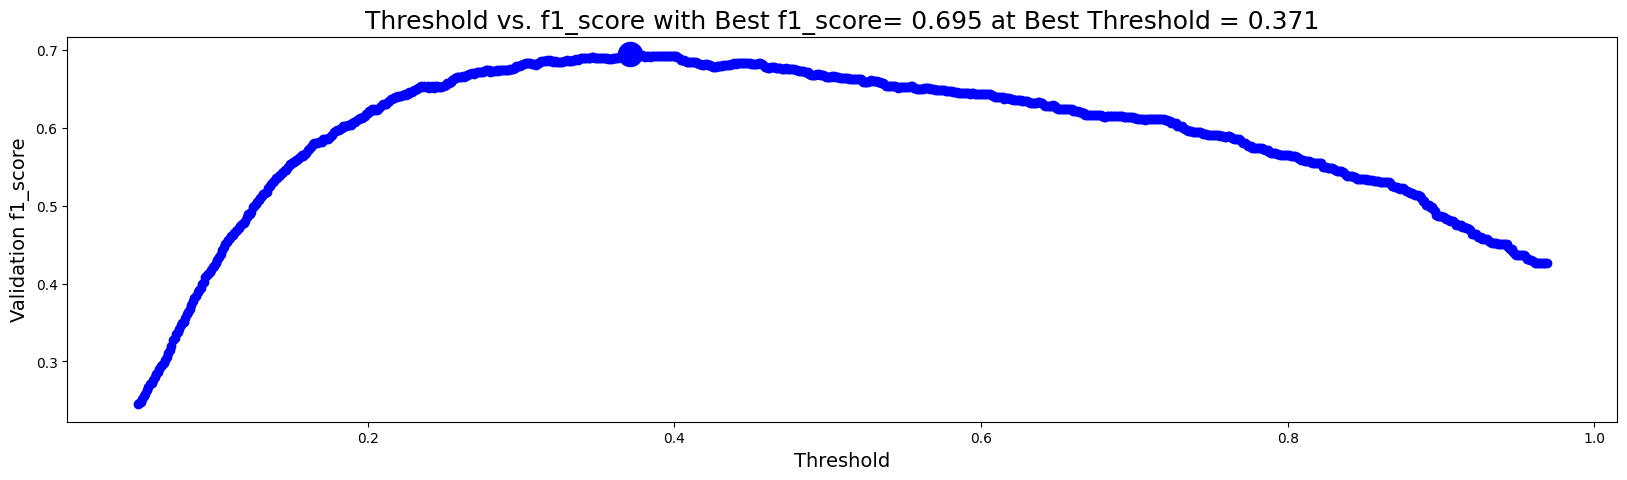

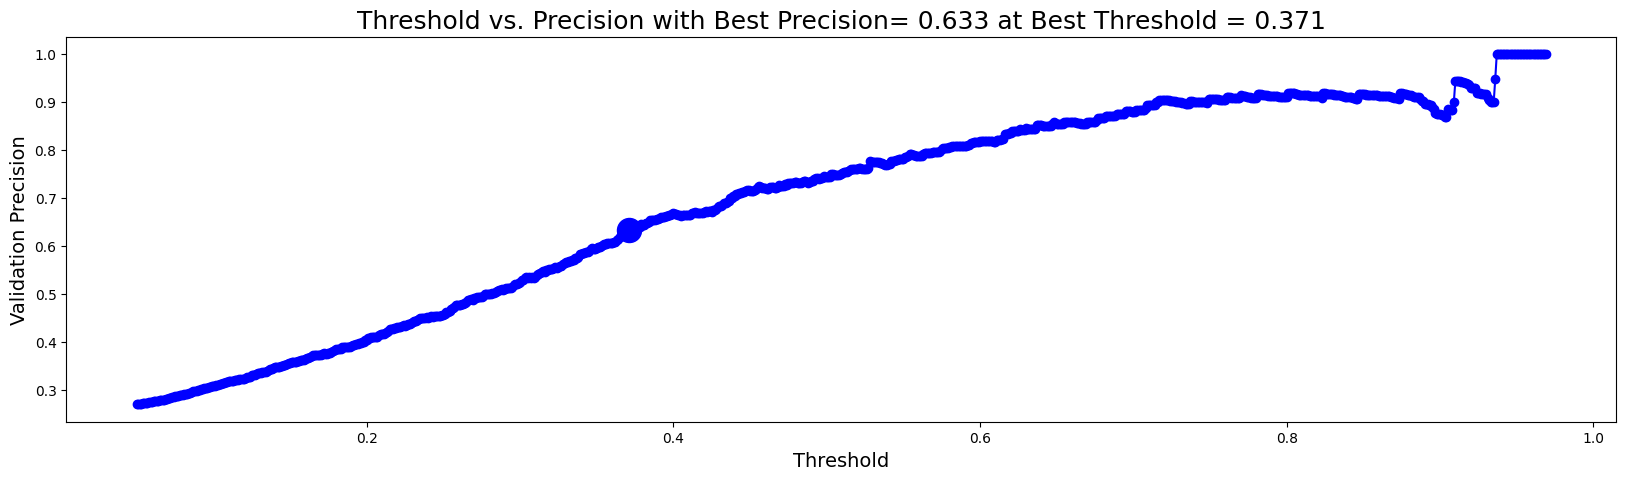

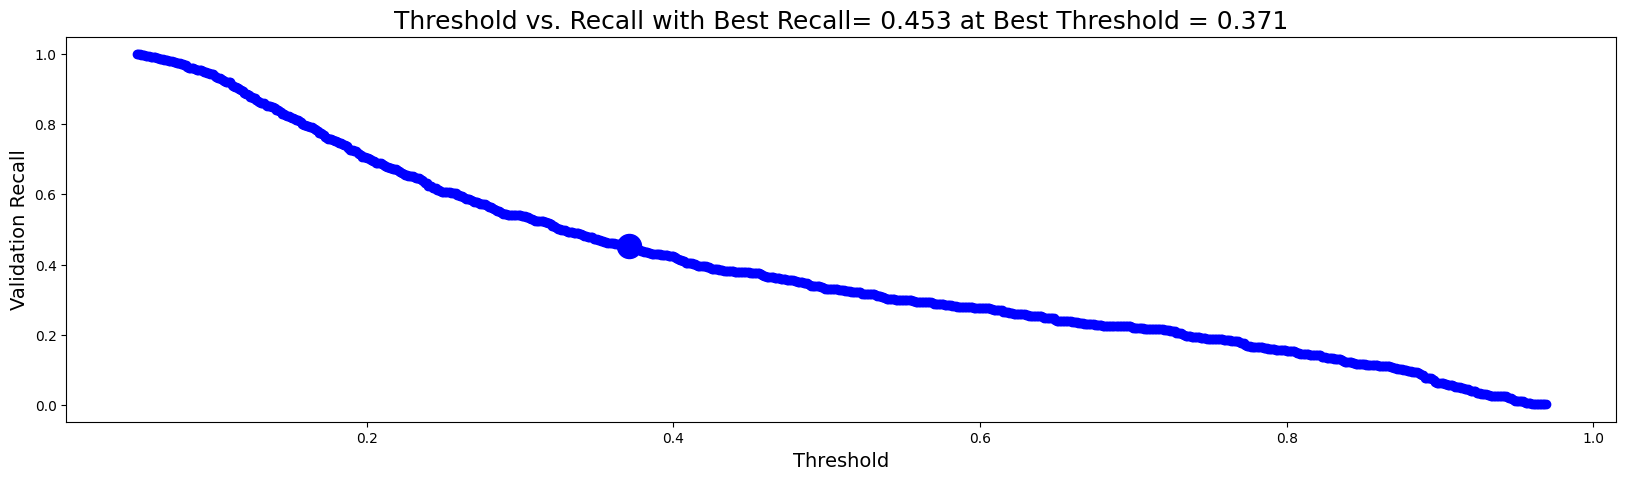

In [ ]:
scores_f1_score=[]
scores_Precision=[]
scores_Recall=[]
scores = []; thresholds = []
best_f1= 0;best_score_pr= 0;best_score_rc = 0; best_threshold = 0
true = y_train
for threshold in np.arange(0.05,0.97,0.001):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    # scores.append(m)
    pr = precision_score(true.values.reshape((-1)), preds)
    rc = recall_score(true.values.reshape((-1)), preds)
    f1 = f1_score(true.values.reshape((-1)), preds,average='macro')
    m= f1_score(true.values.reshape((-1)), preds,average='macro')
    scores_f1_score.append(f1)
    scores_Precision.append(pr)
    scores_Recall.append(rc)
    thresholds.append(threshold)
    if m>best_f1:
        best_f1 = m
        best_score_pr = pr
        best_score_rc = rc
        best_threshold = threshold
scores_dict = {
            'f1_score':[scores_f1_score,best_f1],
            'Precision':[scores_Precision,best_score_pr],
            'Recall':[scores_Recall,best_score_rc]}
for i in scores_dict.keys():
  plot(scores_dict[i][0],scores_dict[i][1],i)

In [ ]:
def catboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for model in models:
        # Predict
        test_pred += model.predict_proba(x_test)[:, 1]
    return test_pred / 7

In [ ]:
pred_cat = catboost_inference(X_test[columns])
pred_marks = (pred_cat> best_threshold).astype('int')

In [ ]:
print(precision_score(y_test, pred_marks))
print(recall_score(y_test,pred_marks))
print(f1_score(y_test, pred_marks,average='macro'))

0.6293103448275862
0.44242424242424244
0.6901270341438692


In [ ]:
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=22)
indx_all = X_train.index

oof = pd.DataFrame(data=np.zeros((len(indx_all),1)), index=indx_all)
# params_grid = {'bootstrap_type': 'MVS',
#         'iterations': 800,
#         'learning_rate': 0.259,
#         'max_depth': 3,
#         'objective': 'Logloss',
#         'verbose': 200,
#         'eval_metric': 'AUC',
#         'border_count': 32,
#         'colsample_bylevel': 0.09715577437674092,
#         'min_data_in_leaf': 20,
#         'random_strength': 0.36494249753665964,
#         'scale_pos_weight': 0.4366210135974975
#         }

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
models=[]
for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    print('#'*25)
    print('### CV_Fold',idx+1)
    print('#'*25)

    X_train_сv, X_val_сv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_сv, y_val_сv = y_train.iloc[train_idx], y_train.iloc[test_idx]

    train_w0, train_w1 = calc_log_loss_weight(y_train_сv)
    valid_w0, valid_w1 = calc_log_loss_weight(y_val_сv)

    train_pool = Pool(X_train_сv[columns], y_train_сv,weight=y_train_сv.map({0: train_w0, 1: train_w1}), feature_names=columns)
    test_pool = Pool(X_val_сv[columns], y_val_сv,weight=y_val_сv.map({0: train_w0, 1: train_w1}), feature_names=columns)

    clf = CatBoostClassifier()
    clf.fit(train_pool,
            eval_set=test_pool,
            verbose=0)
    models.append(clf)
    oof.loc[X_val_сv.index,0] = clf.predict_proba(X_val_сv.astype('float32'))[:,1]
    y_pred_metki = clf.predict(X_val_сv)
    y_pred = clf.predict_proba(X_val_сv)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val_сv, y_pred)
    print("AUC_ROC----"+str(roc_auc_score(y_val_сv, y_pred)))
    print("F1-score-----"+str(f1_score(y_val_сv, y_pred_metki,average='macro')))

#########################
### CV_Fold 1
#########################
AUC_ROC----0.7608678184009642
F1-score-----0.6861478480238513
#########################
### CV_Fold 2
#########################
AUC_ROC----0.7426275612695861
F1-score-----0.666614785992218
#########################
### CV_Fold 3
#########################
AUC_ROC----0.7070220855917806
F1-score-----0.6432089317066583
#########################
### CV_Fold 4
#########################
AUC_ROC----0.7906318259040531
F1-score-----0.6899300056199866
#########################
### CV_Fold 5
#########################
AUC_ROC----0.7804789256532642
F1-score-----0.699327238226669
#########################
### CV_Fold 6
#########################
AUC_ROC----0.7224094526555142
F1-score-----0.6628497632371932
#########################
### CV_Fold 7
#########################
AUC_ROC----0.7506699691408153
F1-score-----0.6637413225489927


In [ ]:
scores_f1_score=[]
scores_Precision=[]
scores_Recall=[]
scores = []; thresholds = []
best_f1= 0;best_score_pr= 0;best_score_rc = 0; best_threshold = 0
true = y_train
for threshold in np.arange(0.05,0.97,0.001):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    # scores.append(m)
    pr = precision_score(true.values.reshape((-1)), preds)
    rc = recall_score(true.values.reshape((-1)), preds)
    f1 = f1_score(true.values.reshape((-1)), preds,average='macro')
    m= f1_score(true.values.reshape((-1)), preds,average='macro')
    scores_f1_score.append(f1)
    scores_Precision.append(pr)
    scores_Recall.append(rc)
    thresholds.append(threshold)
    if m>best_f1:
        best_f1 = m
        best_score_pr = pr
        best_score_rc = rc
        best_threshold = threshold
scores_dict = {
            'f1_score':[scores_f1_score,best_f1],
            'Precision':[scores_Precision,best_score_pr],
            'Recall':[scores_Recall,best_score_rc]}

0.05, 0.05, 0.05, 0.05, 0.05, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.22, 0.22

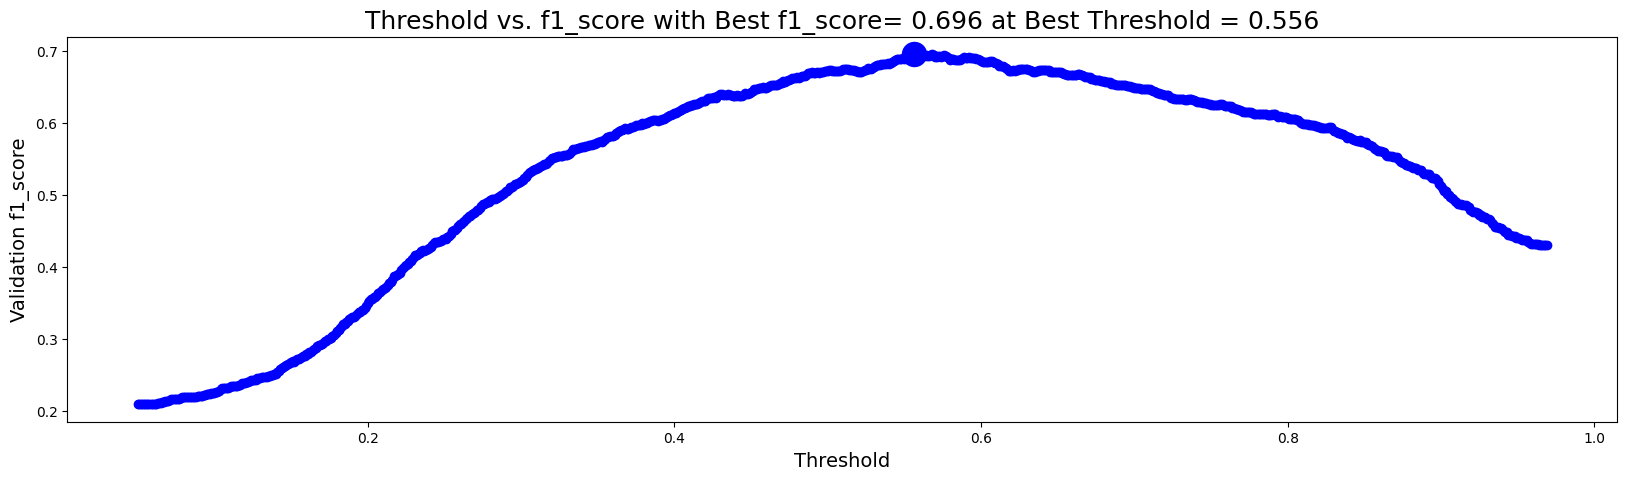

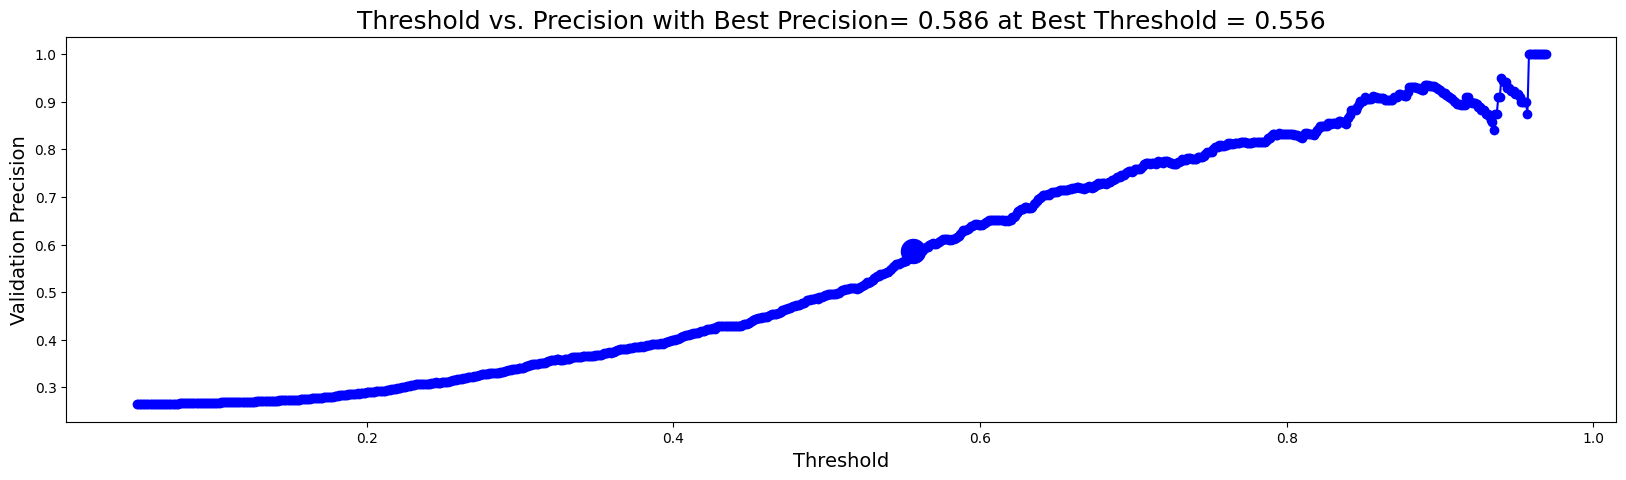

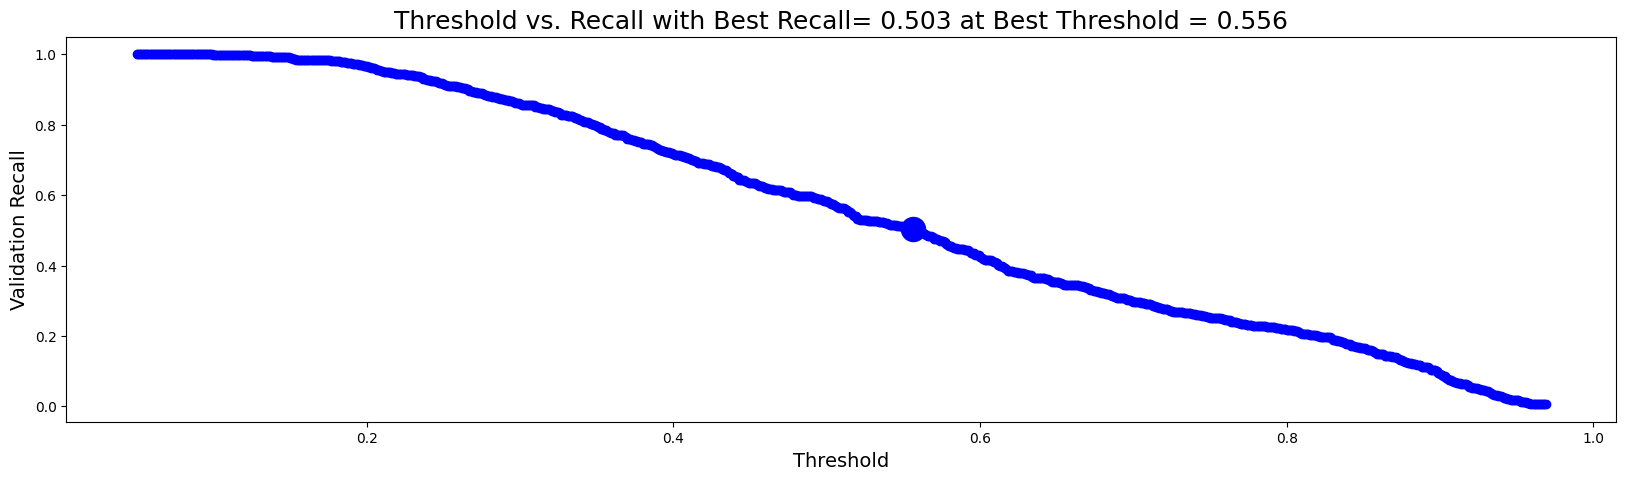

In [ ]:
  for i in scores_dict.keys():
  plot(scores_dict[i][0],scores_dict[i][1],i)

In [ ]:
pred_cat = catboost_inference(X_test[columns])
pred_marks = (pred_cat> best_threshold).astype('int')

In [ ]:
print(precision_score(y_test, pred_marks))
print(recall_score(y_test,pred_marks))
print(f1_score(y_test, pred_marks,average='macro'))

0.5955882352941176
0.4909090909090909
0.6958680058393343
